In [1]:
# CAP 5415 Programming Assignment 04: Image Classification

"""
Design a CNN architecture which has more then 2 convolutional layers and more then 1 fully connected layers. It should make 10 predictions for the 10 classes of CIFAR-10.

1. Train this network on CIFAR-10 for 30 epochs
2. Use Cross-Entropy Loss
3. SGD Optimizer
4. Softmax activation after the final fully connected layer.
5. Report Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs.

6. Finally, increase the number of conv layers in the above network and train again. Report the same numbers and plots again comparing with the first network.


"""

'\nDesign a CNN architecture which has more then 2 convolutional layers and more then 1 fully connected layers. It should make 10 predictions for the 10 classes of CIFAR-10.\n\n1. Train this network on CIFAR-10 for 30 epochs\n2. Use Cross-Entropy Loss\n3. SGD Optimizer\n4. Softmax activation after the final fully connected layer.\n5. Report Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs.\n\n6. Finally, increase the number of conv layers in the above network and train again. Report the same numbers and plots again comparing with the first network.\n\n\n'

In [2]:
# =======================================================#
# 1. Import basic Modules and Functions and set variables
# =======================================================#

import torch
import torch.nn as nn # All the Neural network models, loss functions
import torch.optim as optim # Optimization algorithms
import torch.nn.functional as F # All functions without parameters
from torch.utils.data import DataLoader # Easier dataset management such as minibatches
import torchvision.datasets as datasets # Standard datasets that can be used as test training data
import torchvision.transforms as transforms # Transformations that can be performed on the dataset
from torchinfo import summary
import matplotlib.pyplot as plt


# Import some packages for logging training and showing progress
from tqdm_loggable.auto import tqdm
from tqdm_loggable.tqdm_logging import tqdm_logging
import datetime
import logging


# Set up some basic logging to record traces of training
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        filename="output/Step_02_output.txt" # Save log to a file
    )

tqdm_logging.set_level(logging.INFO)


# Hyperparameters
input_channels = 3
hidden_size = 100
num_classes= 10
learning_rate = 0.01
batch_size = 10
num_epochs = 30
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/malneyugnfl/softwaredev/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/malneyugnfl/softwaredev/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# =========================================================================================================#
# 2. Increase the number of convolutional layers in the network:
# =========================================================================================================#

class NN_2(nn.Module):
    def __init__(self,input_channels,hidden_size, num_classes):
        super(NN_2, self).__init__() # The Super keyword calls the initialization of the parent class
        
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=40,
                               kernel_size=(5,5),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.conv2 = nn.Conv2d(in_channels=40,
                               out_channels=40,
                               kernel_size=(5,5),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.conv3 = nn.Conv2d(in_channels=40,
                               out_channels=40,
                               kernel_size=(2,2),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.conv4 = nn.Conv2d(in_channels=40,
                               out_channels=40,
                               kernel_size=(2,2),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.pool = nn.MaxPool2d(kernel_size=(2,2),
                                  stride=(2,2)
        ) 
        self.fc1 = nn.Linear(40*3*3, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def num_flat_features(self,x):
        size = x.size()[1:] # all dimensions except batch dimension
        num_features = 1
        for s in size:
            num_features *=s

        return num_features

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1)

        return x

In [4]:
# =======================================================#
# 3. Load and prepare dataset:
# =======================================================#

train_dataset = datasets.CIFAR10(root='dataset/', 
               train=True, 
               transform=transforms.ToTensor(),
               download=True
               )#Transforms transforms numpy array to tensors so that pytorch can use the data


train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_dataset = datasets.CIFAR10(root='dataset/', 
               train=False, 
               transform=transforms.ToTensor(),
               download=True
               )#Transforms transforms numpy array to tensors so that pytorch can use the data

test_loader = DataLoader(
    dataset= test_dataset,
    batch_size = batch_size,
    shuffle = True
)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# =======================================================#
# 4. Define Accuracy Function:
# =======================================================#

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
        logging.info("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")
        logging.info("Checking accuracy on test data")
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad(): # No gradients have to be calculated
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples) * 100:.2f}')
        logging.info(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples) * 100:.2f}')

    model.train()
    acc = float(num_correct)/float(num_samples)
    return acc

In [6]:
# =======================================================#
# 5. Train the Updated Convolutional Neural Network:
# =======================================================#

#Initialize Model
model = NN_2(
    input_channels=input_channels,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device)

logging.info(f"Begin Training CIFAR-10 dataset with this model: {model}")

# Define the loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

# Set Some state variables
epoch_counter= 0
current_loss = 1
current_accuracy = 1
model_accuracy = []
model_loss = []


# Train Network
for epoch in range(num_epochs):
    if epoch > 0:
        current_accuracy = check_accuracy(train_loader,model)
        model_accuracy.append(current_accuracy)
        model_loss.append(round(current_loss, 4))
    tqdm.write(f"Step 2/2 Training Epoch {epoch+1}/{num_epochs}")
    # store points for for plotting the accuracy and loss:
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):

        
        # Get data to Cuda/gpu if possible
        data = data.to(device=device)
        targets = targets = targets.to(device=device)
    
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Go Backward in the network:
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        current_loss = loss.item()
        # logging.info("Training single layer Neural Network ")
        if epoch > epoch_counter+4:
            logging.info(f"Training Epoch: {epoch}, loss = {loss.item():.4f}")

            epoch_counter = epoch


epoch_counter = 0

# Save the trained model
torch.save(model.state_dict(),'trained_models/Classifier_02.pth')

Step 2/2 Training Epoch 1/30


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x100 and 640x100)

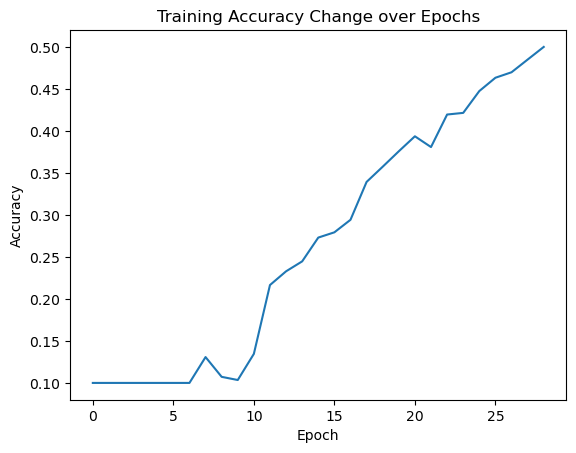

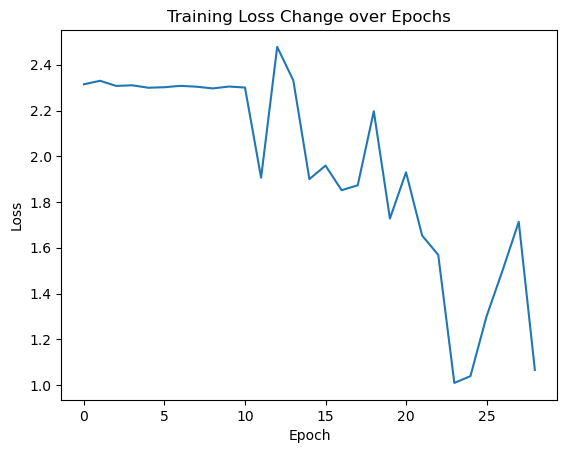

In [ ]:
# =========================================================================================================#
# 10. Graph Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs:
# =========================================================================================================#

epoch_list = []

for i in range(len(model_accuracy)):
    epoch_list.append(i)

# Plot Accuracy
plt.plot(epoch_list, model_accuracy)
plt.title("Training Accuracy Change over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig("output/Step_02_Accuracy.png")
plt.show()

# Plot Loss
plt.plot(epoch_list, model_loss)
plt.title("Training Loss Change over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("output/Step_02_Loss.png")
plt.show()
